# Notebook for Neural Network

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.metrics import Precision, Recall, Accuracy

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pipe import select, where, sort
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, fbeta_score, make_scorer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
import presentation as p 

In [3]:
training_df = pd.read_csv('data/network-traffic/kddcup.data.corrected.csv', index_col=False).drop_duplicates()
testing_df = pd.read_csv('data/network-traffic/corrected.csv', index_col=False).drop_duplicates()
complete_df = pd.read_csv('data/network-traffic/kddcup.data.complete.csv', index_col=False).drop_duplicates()

In [4]:
# Create column to verify if it is an attack or not
training_df['is_attack'] = training_df.target.map(lambda a_type: a_type != 'normal')
testing_df['is_attack'] = testing_df.target.map(lambda a_type: a_type != 'normal')
complete_df['is_attack'] = complete_df.target.map(lambda a_type: a_type != 'normal')

In [5]:
# Metrics
beta =10
fbeta_scorer = make_scorer(fbeta_score, beta=beta)

In [6]:
# Important Data Subset (15 Most Important Features)
feature_imp_attack = {
   'same_srv_rate': 0.21199866684770505, 'count': 0.1385794555921013, 'diff_srv_rate': 0.11660354574720663, 
   'src_bytes': 0.07133604504271888, 'flag': 0.0689813541719748, 'dst_host_srv_serror_rate': 0.0621598020912925, 
   'dst_bytes': 0.057168688956664895, 'dst_host_same_srv_rate': 0.05254858459557669, 'srv_serror_rate': 0.04469331875735019, 
   'serror_rate': 0.04097324469080398, 'service': 0.01868051080047695, 'dst_host_serror_rate': 0.01802081827734208, 
   'dst_host_srv_count': 0.011545183650792126, 'dst_host_same_src_port_rate': 0.011337335403034117, 'protocol_type': 0.01111283067949643, 
   'srv_count': 0.009167672319969513, 'dst_host_count': 0.00873490361773566, 'dst_host_srv_rerror_rate': 0.008354143406230159, 
   'dst_host_diff_srv_rate': 0.007982036329319523, 'logged_in': 0.007096409133012435, 'dst_host_srv_diff_host_rate': 0.006912055417103559, 
   'dst_host_rerror_rate': 0.0048513483664072345, 'rerror_rate': 0.0025784179881967813, 'wrong_fragment': 0.0020432908004560796, 
   'srv_rerror_rate': 0.0016133665984154693, 'num_compromised': 0.001456082442758954, 'duration': 0.0013066127485688805, 
   'hot': 0.0012589559107352938, 'srv_diff_host_rate': 0.0006086465735149157, 'is_guest_login': 0.00013464784144864953, 
   'num_root': 4.6925733316063196e-05, 'num_failed_logins': 4.487859382061017e-05, 'num_file_creations': 2.0557845839487765e-05, 
   'root_shell': 1.7416012225572053e-05, 'num_access_files': 1.2171215578937403e-05, 'num_shells': 8.344719212122783e-06, 
   'urgent': 4.825536792287678e-06, 'land': 4.449872331211087e-06, 'su_attempted': 2.354686052141186e-06, 
   'is_host_login': 1.0098642182210754e-07, 'num_outbound_cmds': 0.0
}

feature_imp_attack_class = {
   'count': 0.17385536847050378, 'dst_host_diff_srv_rate': 0.16534192463609285, 'diff_srv_rate': 0.10254320729049028, 
   'dst_host_same_src_port_rate': 0.08935524484241128, 'src_bytes': 0.06294894120539953, 'same_srv_rate': 0.06266221897844468, 
   'srv_count': 0.033477361412496846, 'dst_host_srv_diff_host_rate': 0.02985837864005727, 'dst_host_serror_rate': 0.02397819057338417, 
   'dst_host_rerror_rate': 0.02270848553479628, 'flag': 0.02261474009181149, 'dst_host_count': 0.02122279595653549, 
   'dst_host_srv_count': 0.02018236362613821, 'rerror_rate': 0.019581932778250603, 'service': 0.01929291941472073, 
   'protocol_type': 0.017131606487459122, 'dst_host_same_srv_rate': 0.016847303696007312, 'srv_diff_host_rate': 0.015281253769726545, 
   'serror_rate': 0.01428655250033731, 'logged_in': 0.010248503497316944, 'dst_host_srv_serror_rate': 0.009237924881051724, 
   'wrong_fragment': 0.007985681738000482, 'duration': 0.007656807637643944, 'srv_serror_rate': 0.006918207069047998, 
   'dst_bytes': 0.006286666021650419, 'dst_host_srv_rerror_rate': 0.005842311030619984, 'hot': 0.005058255448651374, 
   'is_guest_login': 0.002493649080574099, 'srv_rerror_rate': 0.0022021571945202234, 'num_compromised': 0.001800962024192526, 
   'num_failed_logins': 0.0004716818681954542, 'root_shell': 0.00018912178300909527, 'num_file_creations': 0.00017914153458179928, 
   'num_root': 9.446178745950394e-05, 'land': 8.349735882600549e-05, 'num_access_files': 3.9353623828989734e-05, 
   'num_shells': 2.1600402461996604e-05, 'urgent': 1.5411543725298135e-05, 'su_attempted': 3.8145695782391786e-06, 
   'num_outbound_cmds': 0.0, 'is_host_login': 0.0
}

def feature(ranking): return ranking[0]
def importance(ranking): return ranking[1]
def top_n_features(n, features):
    return list(
        list(features.items())
        | sort(importance, reverse=True)
        | select(feature)
    )[:n]
def features_above(threshold, features):
    return list(
        list(features.items())
        | where(lambda feature: importance(feature) >= threshold)
        | select(feature)
    )

In [7]:
# For SVM, we will restrict ourselves to the top 15 respective most important features.
top_features_attack = top_n_features(15, feature_imp_attack)
top_features_attack_class = top_n_features(15, feature_imp_attack_class)

In [8]:
# Scale Integer and Float variables
scalable_columns = [col for col in complete_df.columns if complete_df[col].dtype in ['int64', 'float64'] and complete_df[col].nunique() > 2]

# Create copies of the data frames
training_df_scaled = training_df.copy()
testing_df_scaled = testing_df.copy()
complete_df_scaled = complete_df.copy()

scaler = StandardScaler()
for col in scalable_columns:
    training_df_scaled[scalable_columns] = scaler.fit_transform(training_df[scalable_columns])
    testing_df_scaled[scalable_columns] = scaler.transform(testing_df[scalable_columns])
    complete_df_scaled[scalable_columns] = scaler.transform(complete_df[scalable_columns])


In [9]:
# Label encode the target and categorical variables
#object_column_names = [complete_df[col].name for col in complete_df.columns if complete_df[col].dtype == 'object']
categorical_columns = ['protocol_type', 'service', 'flag', 'target', 'attack_class', 'is_attack']

label_encoder = LabelEncoder()
# Fit the label encoder on the complete dataset
for col in categorical_columns:
    label_encoder.fit(complete_df[col])
    training_df[col] = label_encoder.transform(training_df[col])
    testing_df[col] = label_encoder.transform(testing_df[col])
    complete_df[col] = label_encoder.transform(complete_df[col])
    training_df_scaled[col] = label_encoder.transform(training_df_scaled[col])
    testing_df_scaled[col] = label_encoder.transform(testing_df_scaled[col])
    complete_df_scaled[col] = label_encoder.transform(complete_df_scaled[col])
    

# Training and Test Data

In [10]:
# Attack Detection Scaled and Reduced Data
X_train_attack_red_scaled = training_df_scaled[top_features_attack]
y_train_attack_red_scaled = training_df_scaled['is_attack']

X_test_attack_red_scaled = testing_df_scaled[top_features_attack]
y_test_attack_red_scaled = testing_df_scaled['is_attack']

# Attack Classification Scaled and Reduced Data
X_train_class_red_scaled = training_df_scaled[training_df_scaled['attack_class'] != 1][top_features_attack_class]
y_train_class_red_scaled = training_df_scaled[training_df_scaled['attack_class'] != 1]['attack_class']

X_test_class_red_scaled = testing_df_scaled[testing_df_scaled['attack_class'] != 1][top_features_attack_class]
y_test_class_red_scaled = testing_df_scaled[testing_df_scaled['attack_class'] != 1]['attack_class']

In [11]:

# Attack Classification Y Values Hot Encoding
y_train_class_enc = pd.get_dummies(y_train_class_red_scaled, prefix='class')
y_test_class_enc = pd.get_dummies(y_test_class_red_scaled, prefix='class')

# Neural Network

In [12]:
# Set random seed for TensorFlow
tf.random.set_seed(404)

metrics = tf.keras.metrics.FBetaScore(beta=10.0, threshold=.5, average='weighted')

In [13]:
# Create Model
nn_attack_model = Sequential([
        Input(shape=(X_train_attack_red_scaled.shape[1],), batch_size=128),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dropout(0.3),
        Dense(1, activation='sigmoid')  # Output layer for binary classification
    ])

# Compile the Attack Detection Model
nn_attack_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[metrics])

In [34]:
nn_class_model = Sequential([
        Input(shape=(X_train_class_red_scaled.shape[1],), batch_size=128),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dropout(0.3),
        Dense(4, activation='softmax')  # Output layer for multi classification
    ])

# Compile the Attack Classification Model
nn_class_model.compile(optimizer='adam', loss='categorical_focal_crossentropy', metrics=[metrics, tf.keras.metrics.Accuracy()])

In [15]:
# Train the Neural Network models with adjusted parameters
history_attack_red_scaled = nn_attack_model.fit(
    X_train_attack_red_scaled, y_train_attack_red_scaled,
    epochs=50, validation_split=0.2
)


Epoch 1/50
26875/26875 ━━━━━━━━━━━━━━━━━━━━ 14s 491us/step - fbeta_score: 0.9650 - loss: 0.0400 - val_fbeta_score: 0.9936 - val_loss: 0.0406
Epoch 2/50
26875/26875 ━━━━━━━━━━━━━━━━━━━━ 13s 495us/step - fbeta_score: 0.9860 - loss: 0.0170 - val_fbeta_score: 0.9947 - val_loss: 0.0435
Epoch 3/50
26875/26875 ━━━━━━━━━━━━━━━━━━━━ 13s 486us/step - fbeta_score: 0.9872 - loss: 0.0146 - val_fbeta_score: 0.9923 - val_loss: 0.0488
Epoch 4/50
26875/26875 ━━━━━━━━━━━━━━━━━━━━ 13s 482us/step - fbeta_score: 0.9883 - loss: 0.0130 - val_fbeta_score: 0.9830 - val_loss: 0.0672
Epoch 5/50
26875/26875 ━━━━━━━━━━━━━━━━━━━━ 13s 482us/step - fbeta_score: 0.9889 - loss: 0.0145 - val_fbeta_score: 0.9948 - val_loss: 0.0265
Epoch 6/50
26875/26875 ━━━━━━━━━━━━━━━━━━━━ 13s 499us/step - fbeta_score: 0.9901 - loss: 0.0117 - val_fbeta_score: 0.9909 - val_loss: 0.0426
Epoch 7/50
26875/26875 ━━━━━━━━━━━━━━━━━━━━ 13s 482us/step - fbeta_score: 0.9928 - loss: 0.0108 - val_fbeta_score: 0.9940 - val_loss: 0.0432
Epoch 8/50
26

In [19]:
history_class_red_scaled = nn_class_model.fit(
    X_train_class_red_scaled, y_train_class_enc,
    epochs=50, validation_split=0.2
)

Epoch 1/50
6555/6555 ━━━━━━━━━━━━━━━━━━━━ 3s 437us/step - accuracy: 0.9646 - loss: 0.2432 - val_accuracy: 0.2354 - val_loss: 5.3098
Epoch 2/50
6555/6555 ━━━━━━━━━━━━━━━━━━━━ 3s 427us/step - accuracy: 0.9968 - loss: 0.0114 - val_accuracy: 0.2357 - val_loss: 8.2024
Epoch 3/50
6555/6555 ━━━━━━━━━━━━━━━━━━━━ 3s 426us/step - accuracy: 0.9977 - loss: 0.0076 - val_accuracy: 0.2360 - val_loss: 8.7421
Epoch 4/50
6555/6555 ━━━━━━━━━━━━━━━━━━━━ 3s 430us/step - accuracy: 0.9981 - loss: 0.0061 - val_accuracy: 0.2330 - val_loss: 8.2987
Epoch 5/50
6555/6555 ━━━━━━━━━━━━━━━━━━━━ 3s 424us/step - accuracy: 0.9984 - loss: 0.0052 - val_accuracy: 0.2355 - val_loss: 13.3860
Epoch 6/50
6555/6555 ━━━━━━━━━━━━━━━━━━━━ 3s 426us/step - accuracy: 0.9985 - loss: 0.0079 - val_accuracy: 0.2357 - val_loss: 12.3920
Epoch 7/50
6555/6555 ━━━━━━━━━━━━━━━━━━━━ 3s 447us/step - accuracy: 0.9985 - loss: 0.0054 - val_accuracy: 0.2360 - val_loss: 13.0314
Epoch 8/50
6555/6555 ━━━━━━━━━━━━━━━━━━━━ 3s 433us/step - accuracy: 0.998

In [21]:
# Evaluate the Neural Network model for Attack Detection
loss, accuracy = nn_attack_model.evaluate(X_test_attack_red_scaled, y_test_attack_red_scaled)
print(f'Neural Network Attack Detection Accuracy: {accuracy:.2f}')

# Evaluate the Neural Network model for Attack Classification
loss, accuracy = nn_class_model.evaluate(X_test_class_red_scaled, y_test_class_enc)
print(f'Neural Network Attack Classification Accuracy: {accuracy:.2f}')


2416/2416 ━━━━━━━━━━━━━━━━━━━━ 1s 267us/step - fbeta_score: 0.7558 - loss: 0.8137
Neural Network Attack Detection Accuracy: 0.82
919/919 ━━━━━━━━━━━━━━━━━━━━ 0s 251us/step - accuracy: 0.4241 - loss: 45.9026
Neural Network Attack Classification Accuracy: 0.42


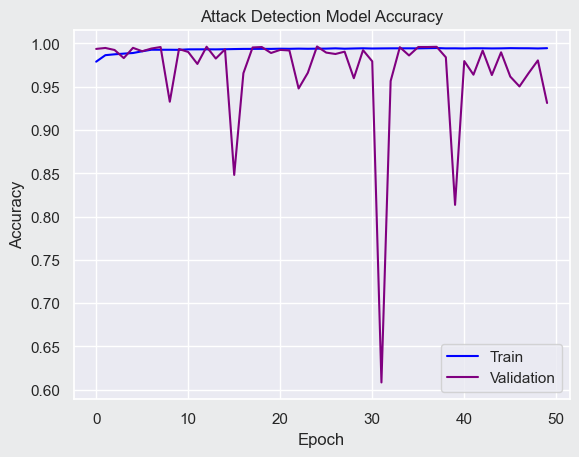

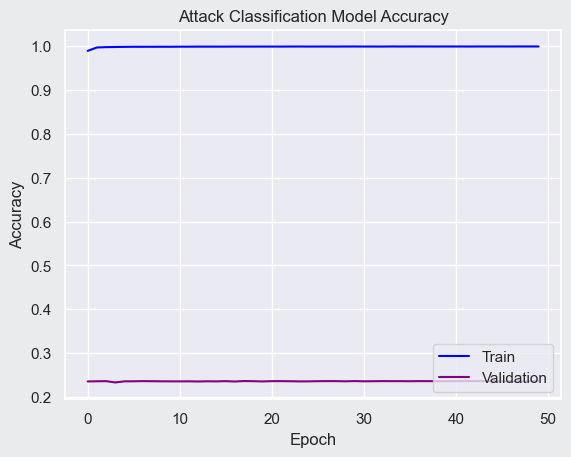

In [22]:
# Visualize the Architecture for Attack Detection
plt.plot(history_attack_red_scaled.history['fbeta_score'], color='blue')
plt.plot(history_attack_red_scaled.history['val_fbeta_score'], color='purple')
plt.title('Attack Detection Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

# Visualize the Architecture for Attack Classification
plt.plot(history_class_red_scaled.history['accuracy'], color='blue')
plt.plot(history_class_red_scaled.history['val_accuracy'], color='purple')
plt.title('Attack Classification Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

In [23]:
import numpy as np

In [24]:
# Pedictions for Attack Detection (Binary)
nn_attack_pred = nn_attack_model.predict(X_test_attack_red_scaled)
predicted_labels_attack = np.where(nn_attack_pred > 0.5, 1, 0)  # Thresholding at 0.5 for binary classification

# Display the first few test samples and their predictions
for i in range(5):
    print(f"Sample {i+1}: True Label: {y_test_attack_red_scaled[i]}, Predicted Label: {predicted_labels_attack[i]}")



2416/2416 ━━━━━━━━━━━━━━━━━━━━ 1s 245us/step
Sample 1: True Label: 0, Predicted Label: [0]
Sample 2: True Label: 1, Predicted Label: [0]
Sample 3: True Label: 1, Predicted Label: [0]
Sample 4: True Label: 1, Predicted Label: [0]
Sample 5: True Label: 0, Predicted Label: [0]


In [30]:
# Predictions for Attack Classification (Multi-class)
nn_class_pred = nn_class_model.predict(X_test_class_red_scaled)
predicted_labels_class = np.argmax(nn_class_pred, axis=1)

# Convert y_test_class_enc to a NumPy array if it isn't already
y_test_class_enc_np = y_test_class_enc.values if isinstance(y_test_class_enc, pd.DataFrame) else y_test_class_enc

# Display the first few test samples and their predictions
for i in range(5):
    true_label = np.argmax(y_test_class_enc_np[i]) 
    print(f"Sample {i+1}: True Label: {true_label}, Predicted Label: {predicted_labels_class[i]}")

919/919 ━━━━━━━━━━━━━━━━━━━━ 0s 233us/step
Sample 1: True Label: 0, Predicted Label: 1
Sample 2: True Label: 0, Predicted Label: 1
Sample 3: True Label: 0, Predicted Label: 1
Sample 4: True Label: 0, Predicted Label: 1
Sample 5: True Label: 0, Predicted Label: 1


Confusion Matrix Attack Detection Neural Network


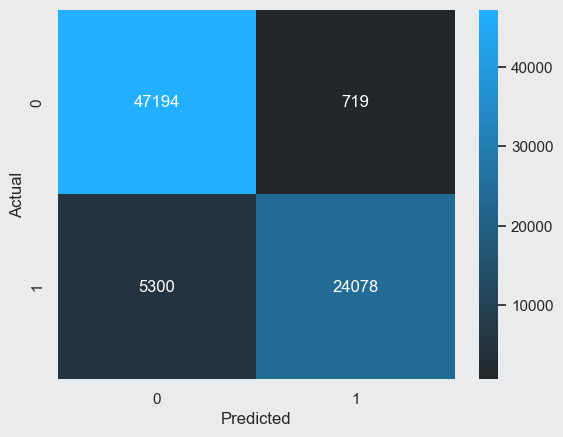

In [27]:
# Confusion Matrix for Attack Detection with Neural Network
print('Confusion Matrix Attack Detection Neural Network')
nn_conf_matrix_attack = confusion_matrix(y_test_attack_red_scaled, predicted_labels_attack)
sns.heatmap(nn_conf_matrix_attack, annot=True, fmt='d', cmap=p.Colors.blues_c)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Confusion Matrix Attack Classification Neural Network


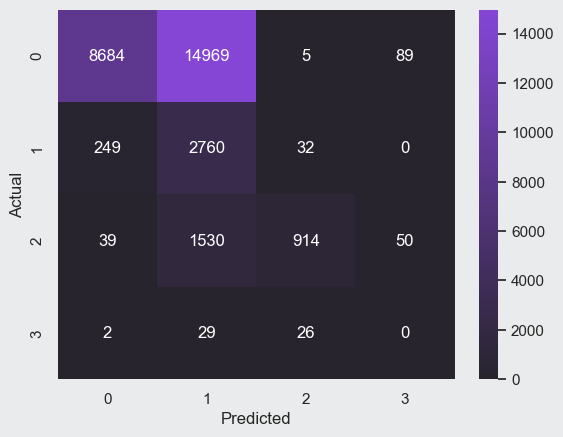

In [33]:
# Convert one-hot encoded y_test_class_enc to class labels
true_labels_class = np.argmax(y_test_class_enc.values, axis=1) if isinstance(y_test_class_enc, pd.DataFrame) else np.argmax(y_test_class_enc, axis=1)

# Confusion Matrix for Attack Classification with Neural Network
print('Confusion Matrix Attack Classification Neural Network')
nn_conf_matrix_class = confusion_matrix(true_labels_class, predicted_labels_class)

# Plot the confusion matrix
sns.heatmap(nn_conf_matrix_class, annot=True, fmt='d', cmap=p.Colors.purples_c)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()